Monte Carlo Estimation
======================
Often we need to estimate intractable expectations in Machine Learning of the form:

$$E\left[f(x)\right] = \int_p {f(x)p(x)}dx$$.


The Monte Carlo estimate is given by
$$E\left[f(x)\right] \approx \frac{1}{N} \sum_{i=1}^{N} {f(x_i)}, \quad \textrm{where}\; x_i \sim p(x_i)$$
How do we find $x_i$? We can use built-in functions for familliar distributions such as `numpy.random.rand()` and `numpy.random.normal()` for sampling from uniform and Gaussian $p(x)$, respectively.

The Problem of Sampling from a Distribution
--------------------------------------------
Given: Arbitrary $p(x)$

Find: $X = [x_1 \cdots x_N]$ such that the samples are distributed according to $p(x)$, i.e, if we draw a histogram of $X$ we see an approximation to $p(x)$

In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import beta
from matplotlib import pyplot as plt
np.random.seed(43)
N=10**3  # number of samples

Inverse CDF
-----------

$$F(x) = Pr(X<x)$$
If $u \sim U(0,1)$, then $F^{-1}(u) \sim F$

In [2]:
lamb=0.4
exp_pdf = lambda x: lamb*np.exp(-lamb*x)
exp_cdf = lambda x: 1-np.exp(-lamb*x)
exp_inv_cdf = lambda p: -(np.log(1-p))/lamb

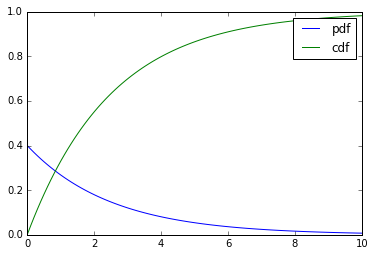

In [3]:
x=np.linspace(0,10,100)
p=exp_pdf(x)
c=exp_cdf(x)
plt.plot(x, p)
plt.plot(x, c)
plt.legend(labels=['pdf', 'cdf']);

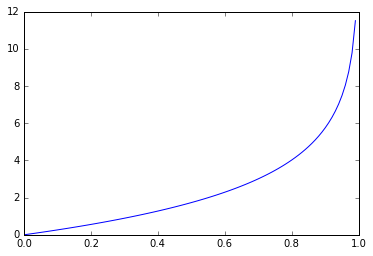

In [4]:
p = np.linspace(0.001,0.99,100)
ic=exp_inv_cdf(p)
plt.plot(p, ic);

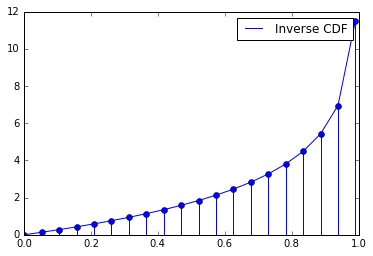

In [5]:
p = np.linspace(0.001,0.99,20)
ic=exp_inv_cdf(p)
fig, ax =plt.subplots()
ax.plot(p, ic);
ax.stem(p, ic)
ax.legend(['Inverse CDF']);

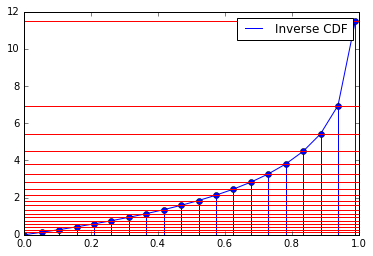

In [6]:
[ax.axhline(y=l, color='red') for l in ic]
fig

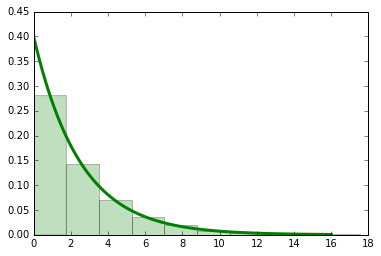

In [7]:
u = np.random.rand(N)
exp_samples=exp_inv_cdf(u)
plt.hist(exp_samples, 10, normed=1, facecolor='green', alpha=0.25)
x=np.linspace(0,16,100)
p=exp_pdf(x)
plt.plot(x,p, linewidth=3);

Rejection Sampling
------------------
Let our target probability distribution be (Remember that we generally don't know how to sample from p(x)):

$$p(x) = \frac{1}{B(\alpha, \beta)} x^{\alpha - 1} (1 - x)^{\beta - 1}$$

and let our proposal distribution be a uniform pdf.

Define the target $p$ and proposal distributions $q$

In [8]:
a=5; b=1.5
truepdf     = lambda x: beta.pdf(x, a=a, b=b) # beta probability distribution
proposalpdf = lambda n: np.random.rand(n)     # uniform probability distribution

Sample from the proposal distribution

In [9]:
q_samples = proposalpdf(N)

Evaluate the probability of the generated samples

In [10]:
p_values = truepdf(q_samples)

Generate uniformly distributed samples

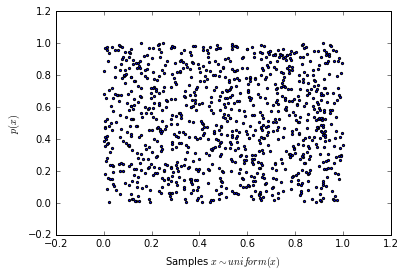

In [11]:
rnd_sample  = np.random.rand(N)  # uniform distribution
fig, ax = plt.subplots()
ax.scatter(q_samples, rnd_sample, marker=".")
ax.set_xlabel('Samples $x \sim uniform(x)$'); ax.set_ylabel('$p(x)$');

These samples however do not encompass our true pdf

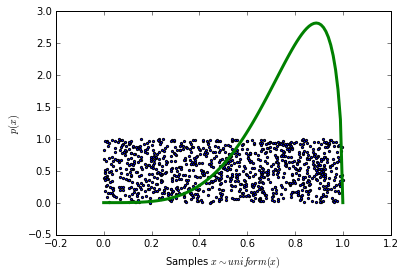

In [12]:
x = np.linspace(0,1,100);
ax.plot(x, truepdf(x), color='green' ,linewidth=3 )
fig

So we scale it by $M$, the maximum value of the true pdf

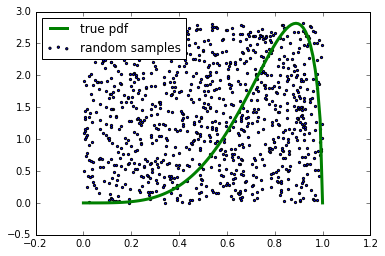

In [13]:
M = max(p_values)
rnd_sample = M*rnd_sample
fig, ax = plt.subplots()
ax.scatter(q_samples, rnd_sample, marker=".", label='random samples')
ax.plot(x, truepdf(x), color='green' ,linewidth=3, label='true pdf' )
ax.legend(loc=2);

Find out acceptable samples

In [14]:
# find out acceptable samples
accepted = rnd_sample < p_values
a_samples = q_samples[accepted]
r_samples = q_samples[~accepted]

Estimated expected value:

In [15]:
np.mean(a_samples)

0.77244358056829099

In [16]:
# Analytical expectation
a/(a+b)

0.7692307692307693

Many samples are rejected

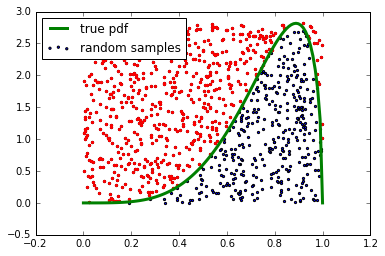

In [17]:
ax.scatter(r_samples, rnd_sample[~accepted], marker=".", color='red')
fig

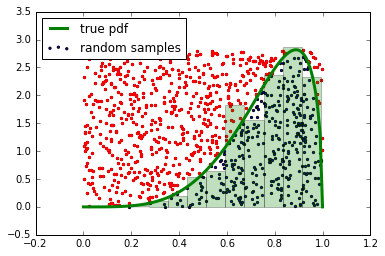

In [18]:
ax.hist(a_samples, 10, normed=1, facecolor='green', alpha=0.25)
fig

In [19]:
rejection_ratio = 100.0*sum(~accepted)/N
rejection_ratio

63.100000000000001

Importance Sampling
-------------------

$$E\left[f(x)\right] = \int_p {f(x)p(x)}dx = \int_p f(x)\left[\frac{p(x)}{q(x)}\right]q(x) dx \quad x \sim q(x)$$

In [20]:
def estimate(f, p, q, qSampler, N):
    # sample from proposal    
    x=qSampler(N)

    # compute weights
    w = p(x)/q(x)
    
    # normalize weights
    w = w/sum(w)
    
    # compute expectation
    fest = sum(w*f(x))
    return fest

In [21]:
# function of x
f = lambda x: x

# target distribution p(x)
p = lambda x: beta.pdf(x, a=a, b=b)

c=(a-1)/(a+b-2) # maximum value of the beta distribution
q = lambda x: c
qSampler = lambda n: np.random.rand(n)      # uniform probability distribution

In [22]:
estimate(f, p, q, qSampler, N)

0.76464389544564559

In [23]:
# Analytical expectation
a/(a+b)

0.7692307692307693